# 「期权研究」50ETF期权之PCR

突然发现joinquant有期权数据，正好研究下PCR和50etf的关系，看看是否能作为一个择时信号。

先import各种包

In [74]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rc
rc("mathtext", default="regular")
import seaborn as sns
sns.set_style("white")
from matplotlib import dates
from pandas import Series,DataFrame,concat
import matplotlib.dates as mdates
from datetime import datetime

### 期权分看跌和看涨两种，买入两种不同的期权，代表着对于后市的不同看法，因此可以引进一个量化指标。

    *  PCR = Put Call Ratio
    *  PCR可以是关于成交量的PCR，也可以是成交额的PCR

期权合约信息可以用jq的opt.OPT_CONTRACT_INFO获得，方便的一b。

In [75]:
start = "2018-01-01"
end = "2019-09-01"
from jqdata import *
q = query(opt.OPT_CONTRACT_INFO).filter(
    opt.OPT_CONTRACT_INFO.underlying_symbol=='510050.XSHG',
    opt.OPT_CONTRACT_INFO.list_date>start,
    opt.OPT_CONTRACT_INFO.list_date<end)
ins = opt.run_query(q)
callOption = ins[ins["contract_type"]=="CO"].code.tolist()
putOption = ins[ins["contract_type"]=="PO"].code.tolist()

In [76]:
codf = get_price(callOption,start_date=start, end_date=end, frequency='daily', fields=["volume","money"], skip_paused=False, fq='pre', count=None, panel=False)
podf = get_price(putOption,start_date=start, end_date=end, frequency='daily', fields=["volume","money"], skip_paused=False, fq='pre', count=None, panel=False)

In [77]:
callvol = pd.pivot_table(codf, values=["money", "volume"], index="time", aggfunc=[np.sum], dropna=True)
putvol = pd.pivot_table(podf, values=["money", "volume"], index="time", aggfunc=[np.sum], dropna=True)

In [90]:
etf = get_price("510050.XSHG",start_date=start, end_date=end, frequency='daily', fields=["close"], skip_paused=False, fq='pre', count=None, panel=False)

### 对比下成交量和成交金额PCR

可以看出走势大致相同

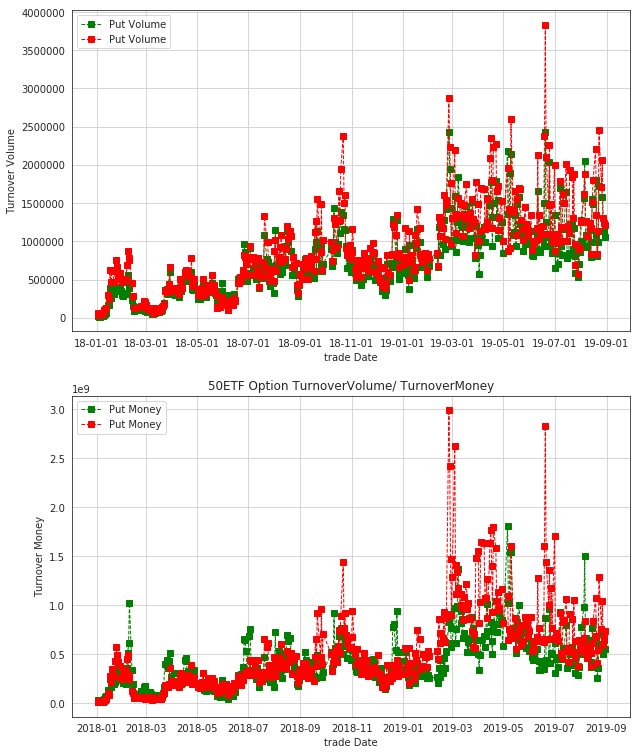

In [79]:
fig = plt.figure(figsize=(10,13))
ax = fig.add_subplot(211)

import matplotlib.dates as mdates
ax.xaxis.set_major_formatter(mdates.DateFormatter('%y-%m-%d'))

ax.plot(putvol.index, putvol["sum", "volume"], '--gs',linewidth=1, label = u'Put Volume')
ax.plot(callvol.index, callvol["sum", "volume"], '--rs',linewidth=1, label = u'Put Volume')

ax.grid()
ax.set_xlabel(u"trade Date")
ax.set_ylabel(r"Turnover Volume")

ax1 = fig.add_subplot(212)
ax1.plot(putvol.index, putvol["sum", "money"], '--gs',linewidth=1, label = u'Put Money')
ax1.plot(callvol.index, callvol["sum", "money"], '--rs',linewidth=1, label = u'Put Money')
ax1.grid()
ax1.set_xlabel(u"trade Date")
ax1.set_ylabel(r"Turnover Money")

ax.legend(loc="best")
ax1.legend(loc="best")
plt.title('50ETF Option TurnoverVolume/ TurnoverMoney')

plt.show()

### 对比50etf走势和基于成交量PCR

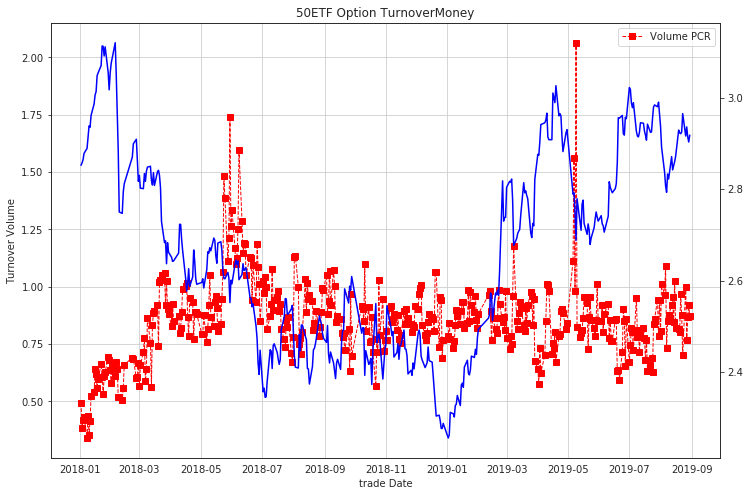

In [89]:
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(111)

import matplotlib.dates as mdates
ax.xaxis.set_major_formatter(mdates.DateFormatter('%y-%m-%d'))

ax.plot(putvol.index, putvol["sum", "volume"]/callvol["sum", "volume"], '--rs',linewidth=1, label = u'Volume PCR')
# ax.plot(callvol.index, putvol["sum", "money"]/callvol["sum", "money"], '--rs', linewidth=1,label = u'Money PCR')
ax.legend(loc="best")

ax2 = ax.twinx()
lns3 = ax2.plot(etf.index, etf.close, 'b-', label = 'ETF closePrice')

ax.grid()
ax.set_xlabel(u"trade Date")
ax.set_ylabel(r"Turnover Volume")
plt.title('50ETF Option TurnoverMoney')

plt.show()

因为两个PCR都差不多，为了更直观的分析就只画了基于成交量的PCR，可以看出：

PCR和价格存在负相关性，价格一路下跌，PCR一路上涨，价格在上升趋势的时候，PCR趋于平稳。方向上的择时可能用近月的PCR来计算比较精确，因为近月的gamma最大，用来判断方向比较合理。有兴趣可以clone自己实现下。